Implement K-Means clustering/ hierarchical clustering on sales_data_sample.csv dataset. Determine the number of clusters using the elbow method
<br>
Dataset link : https://www.kaggle.com/datasets/kyanyoga/sample-sales-data

Sample Sales Data, Order Info, Sales, Customer, Shipping, etc., Used for Segmentation, Customer Analytics, Clustering and More. Inspired for retail analytics. This was originally used for Pentaho DI Kettle, But I found the set could be useful for Sales Simulation training.

Originally Written by María Carina Roldán, Pentaho Community Member, BI consultant (Assert Solutions), Argentina. This work is licensed under the Creative Commons Attribution-Noncommercial-Share Alike 3.0 Unported License. Modified by Gus Segura June 2014.



In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.color_palette("Set2")
import datetime as dt

In [2]:
df = pd.read_csv('data/sales_data_sample.csv',encoding="Latin-1")

In [3]:
if ~df.empty:
    print("Loaded!")

Loaded!


In [4]:
print(df.shape)
print(df.columns)

(2823, 25)
Index(['ORDERNUMBER', 'QUANTITYORDERED', 'PRICEEACH', 'ORDERLINENUMBER',
       'SALES', 'ORDERDATE', 'STATUS', 'QTR_ID', 'MONTH_ID', 'YEAR_ID',
       'PRODUCTLINE', 'MSRP', 'PRODUCTCODE', 'CUSTOMERNAME', 'PHONE',
       'ADDRESSLINE1', 'ADDRESSLINE2', 'CITY', 'STATE', 'POSTALCODE',
       'COUNTRY', 'TERRITORY', 'CONTACTLASTNAME', 'CONTACTFIRSTNAME',
       'DEALSIZE'],
      dtype='object')


In [5]:
df.columns = df.columns.str.lower()

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2823 entries, 0 to 2822
Data columns (total 25 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ordernumber       2823 non-null   int64  
 1   quantityordered   2823 non-null   int64  
 2   priceeach         2823 non-null   float64
 3   orderlinenumber   2823 non-null   int64  
 4   sales             2823 non-null   float64
 5   orderdate         2823 non-null   object 
 6   status            2823 non-null   object 
 7   qtr_id            2823 non-null   int64  
 8   month_id          2823 non-null   int64  
 9   year_id           2823 non-null   int64  
 10  productline       2823 non-null   object 
 11  msrp              2823 non-null   int64  
 12  productcode       2823 non-null   object 
 13  customername      2823 non-null   object 
 14  phone             2823 non-null   object 
 15  addressline1      2823 non-null   object 
 16  addressline2      302 non-null    object 


In [7]:
df.head(3)

,ordernumber,quantityordered,priceeach,orderlinenumber,sales,orderdate,status,qtr_id,month_id,year_id,...,addressline1,addressline2,city,state,postalcode,country,territory,contactlastname,contactfirstname,dealsize
0,10107,30,95.70,2,2871.00,2/24/2003 0:00,Shipped,1,2,2003,...,897 Long Airport Avenue,NaN,NYC,NY,10022,USA,NaN,Yu,Kwai,Small
1,10121,34,81.35,5,2765.90,5/7/2003 0:00,Shipped,2,5,2003,...,59 rue de l'Abbaye,NaN,Reims,NaN,51100,France,EMEA,Henriot,Paul,Small
2,10134,41,94.74,2,3884.34,7/1/2003 0:00,Shipped,3,7,2003,...,27 rue du Colonel Pierre Avia,NaN,Paris,NaN,75508,France,EMEA,Da Cunha,Daniel,Medium


### Preprocess dataset

- Removing redundant features
- Handling NA values
- Removing duplicates
- Feature construction
- Categorical to quantitative
- Handling outliers
- Separating features from target variable
- standardization
- EDA and visualize

### Model building

- Train,test split
- Model building
- Model fitting
- Model evaluation
- Prediction

In [8]:
#preprocessing
df.nunique().sort_values()

dealsize               3
territory              3
year_id                3
qtr_id                 4
status                 6
productline            7
addressline2           9
month_id              12
state                 16
orderlinenumber       18
country               19
quantityordered       58
contactfirstname      72
city                  73
postalcode            73
contactlastname       77
msrp                  80
phone                 91
addressline1          92
customername          92
productcode          109
orderdate            252
ordernumber          307
priceeach           1016
sales               2763
dtype: int64

In [9]:
#removing unnecessary data

In [10]:
drop_features = ["ordernumber","contactfirstname","contactlastname","postalcode","addressline2","addressline1","phone","productcode",'state',"territory"]
df.drop(columns = drop_features,axis = 1,inplace=True)

In [11]:
df.rename(columns = {
    "month_id":"month",
    "year_id":"year",
    "qtr_id":"quarter",
    "quantityordered":"frequency",
    "sales":"monetory"
},inplace=True)

df.head(3)

,frequency,priceeach,orderlinenumber,monetory,orderdate,status,quarter,month,year,productline,msrp,customername,city,country,dealsize
0,30,95.70,2,2871.00,2/24/2003 0:00,Shipped,1,2,2003,Motorcycles,95,Land of Toys Inc.,NYC,USA,Small
1,34,81.35,5,2765.90,5/7/2003 0:00,Shipped,2,5,2003,Motorcycles,95,Reims Collectables,Reims,France,Small
2,41,94.74,2,3884.34,7/1/2003 0:00,Shipped,3,7,2003,Motorcycles,95,Lyon Souveniers,Paris,France,Medium


In [12]:
#handling NA values

In [13]:
pd.DataFrame(df.isnull().sum().sort_values(),columns = ["NA values"]).transpose()

,frequency,priceeach,orderlinenumber,monetory,orderdate,status,quarter,month,year,productline,msrp,customername,city,country,dealsize
NA values,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [14]:
#Feature construction - recency

What Is Recency, Frequency, Monetary Value (RFM)?<br>
Recency, frequency, monetary value (RFM) is a model used in marketing analysis that segments a company's consumer base by their purchasing patterns or habits. In particular, it evaluates customers' recency (how long ago they made a purchase), frequency (how often they make purchases), and monetary value (how much money they spend).
<br>
RFM is then used to identify a company's or an organization's best customers by measuring and analyzing spending habits in order to improve low-scoring customers and maintain high-scoring ones.
<br>

In [15]:
df['orderdate'] = pd.to_datetime(df['orderdate'])

In [16]:
# most recent date from dataset  + 1 day (to count last as well for the recency)
Now = df['orderdate'].max() + dt.timedelta(1)


df_RFM = df.groupby('customername').agg({
    "orderdate":lambda prevdate: (Now - prevdate.max()).days,
    "frequency":"count",
    "monetory":"sum"
})

df_RFM.rename(columns = {"orderdate":"recency"},inplace=True)

In [17]:
df_RFM.head(5)

,recency,frequency,monetory
customername,,,
"AV Stores, Co.",196,51,157807.81
Alpha Cognac,65,20,70488.44
Amica Models & Co.,265,26,94117.26
"Anna's Decorations, Ltd",84,46,153996.13
Atelier graphique,188,7,24179.96


In [18]:
RFM = df_RFM.copy(deep=True)

In RFM model,for each customer, we will assign a score (between 1 to 4) for (R,F,M) to analyze the significance of customer towards (R,F,M).

here, `quartile` has been used i.e binning values `[0-0.25,0.25-0.5, 0.5- 0.75,0.75-1] percentile`

In [19]:
df_RFM["R"] = pd.qcut(df_RFM['recency'],q = 4,labels = range(1,5))

df_RFM["F"] = pd.qcut(df_RFM['frequency'],q = 4,labels = [4,3,2,1])

df_RFM["M"] = pd.qcut(df_RFM['monetory'],q = 4,labels = range(1,5))

In [20]:
df_RFM['RFM_score'] = df_RFM[["R","F","M"]].sum(axis = 1)
df_RFM.head(4)

,recency,frequency,monetory,R,F,M,RFM_score
customername,,,,,,,
"AV Stores, Co.",196,51,157807.81,3,1,4,8
Alpha Cognac,65,20,70488.44,1,3,2,6
Amica Models & Co.,265,26,94117.26,4,3,3,10
"Anna's Decorations, Ltd",84,46,153996.13,2,1,4,7


In [21]:
def sig_level(customer):
    if customer["RFM_score"] >= 10: return "High"
    elif ((customer["RFM_score"] < 10) and (customer["RFM_score"] >= 6)): return "Medium"
    else: return "Low"
        

df_RFM["significance_level"] = df_RFM.apply(sig_level,axis = 1)

In [22]:
df_RFM

,recency,frequency,monetory,R,F,M,RFM_score,significance_level
customername,,,,,,,,
"AV Stores, Co.",196,51,157807.81,3,1,4,8,Medium
Alpha Cognac,65,20,70488.44,1,3,2,6,Medium
Amica Models & Co.,265,26,94117.26,4,3,3,10,High
"Anna's Decorations, Ltd",84,46,153996.13,2,1,4,7,Medium
Atelier graphique,188,7,24179.96,3,4,1,8,Medium
...,...,...,...,...,...,...,...,...
"Vida Sport, Ltd",275,31,117713.56,4,2,3,9,Medium
Vitachrome Inc.,208,25,88041.26,3,3,3,9,Medium
"Volvo Model Replicas, Co",194,19,75754.88,3,4,2,9,Medium


In [23]:
proportion = df_RFM.significance_level.value_counts(normalize = True)

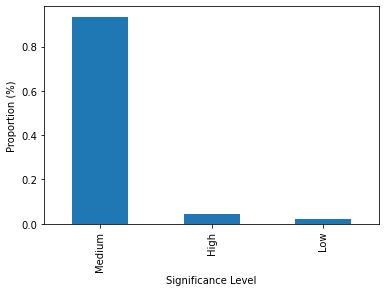

In [24]:
plt.figure()
proportion.plot(kind = 'bar')
plt.ylabel("Proportion (%)")
plt.xlabel("Significance Level")
plt.show()

## K-Means clustering 

In [25]:
#normalize
RFM_norm = (RFM - RFM.mean())/RFM.std()
print(RFM_norm.shape)
RFM_norm.head(3)

(92, 3)


,recency,frequency,monetory
customername,,,
"AV Stores, Co.",0.100242,0.656717,0.442010
Alpha Cognac,-0.896558,-0.345400,-0.349582
Amica Models & Co.,0.625275,-0.151442,-0.135375


### Using elbow method to determine number of clusters

In [26]:
from sklearn.cluster import KMeans

In [27]:
#elbow method
values = []    
n = 11

for k in range(1,n):
    model = KMeans(n_clusters = k,random_state= 42)
    model.fit(RFM_norm)
    values.append(model.inertia_)

n_clusters = list(range(1,n))

In [28]:
assert len(values) == len(n_clusters), "Not Equal"

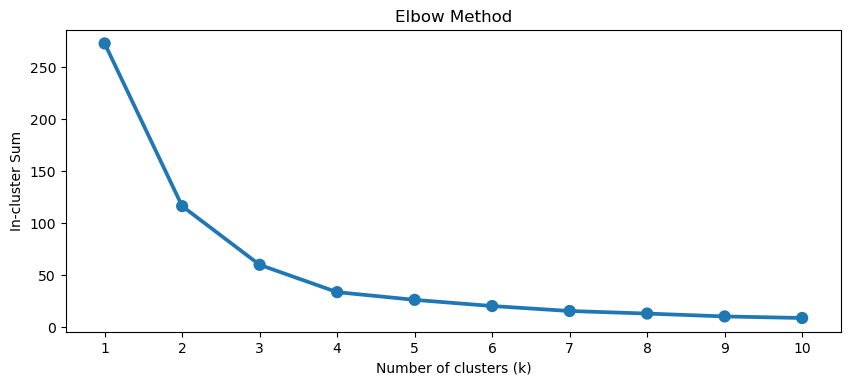

In [29]:
plt.figure(figsize = [10,4],dpi = 100)
plt.title("Elbow Method")
plt.xlabel("Number of clusters (k)")
plt.ylabel("In-cluster Sum")
sns.pointplot(x = n_clusters,y = values)
plt.show()

#### optimal choice of k = 3

In [30]:
from sklearn.decomposition import PCA
pca = PCA(2)
RFM_pca = pca.fit_transform(RFM_norm)
RFM_pca = pd.DataFrame(RFM_pca,columns = ['comp1',"comp2"])
RFM_pca.head(3)

,comp1,comp2
0,0.687927,0.375104
1,-0.133731,-1.013606
2,-0.415305,0.509482


In [31]:
#fitting final model
model = KMeans(n_clusters = 3)
model.fit(RFM_pca)
RFM_pca['clusters'] = model.labels_
RFM_pca.head(3)

,comp1,comp2,clusters
0,0.687927,0.375104,1
1,-0.133731,-1.013606,1
2,-0.415305,0.509482,1


In [32]:
centroids = model.cluster_centers_

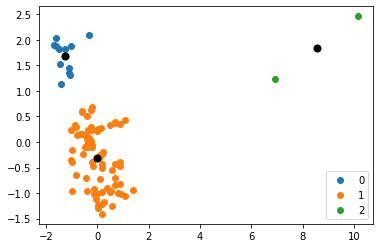

In [36]:
clusters = np.unique(model.labels_)
for k in clusters:
    x = RFM_pca[RFM_pca.clusters == k]['comp1']
    y = RFM_pca[RFM_pca.clusters == k]['comp2']
    
    plt.scatter(x,y,label = k)
    
plt.scatter(centroids[:,0],centroids[:,1],s=50,color = 'k')
plt.legend()
plt.show()